In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import glob
import os
import re

import utilities as ut
import modularised_utils as mut
from load_results import load_results, list_available_results


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

In [4]:
label_map_empirical = {
                        'DIROCA (eps_0.107_delta_0.035)': 'DiRoCA_star',
                        'DIROCA (eps_1.0_delta_1.0)': 'DIROCA_1',
                        'DIROCA (eps_2.0_delta_2.0)': 'DIROCA_2',
                        'DIROCA (eps_4.0_delta_4.0)': 'DIROCA_4',
                        'DIROCA (eps_8.0_delta_8.0)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA',
                        'Abs-LiNGAM (Perfect)': 'Abslin_p',
                        'Abs-LiNGAM (Noisy)': 'Abslin_n'
                    }
label_map_gaussian = {
                        'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA'
                    }

print_label_map  = {
                        'DiRoCA_star':  r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$',
                        'DIROCA_1':     r'DiRoCA$_{1,1}$',
                        'DIROCA_2':     r'DiRoCA$_{2,2}$',
                        'DIROCA_4':     r'DiRoCA$_{4,4}$',
                        'DIROCA_8':     r'DiRoCA$_{8,8}$',
                        'GradCA':       r'GRAD$_{(\tau, \omega)}$',
                        'BARYCA':       r'GRAD$_{\text{bary}}$',
                        'Abslin_p':     r'AbsLin$_{\text{p}}$', 
                        'Abslin_n':     r'AbsLin$_{\text{n}}$'
                    }

### Fix σ, vary α

Data loaded for 'slc'.
Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250726_132833.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'slc'.
Loading: empirical_evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250727_113949.csv
Parameters: empirical additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True


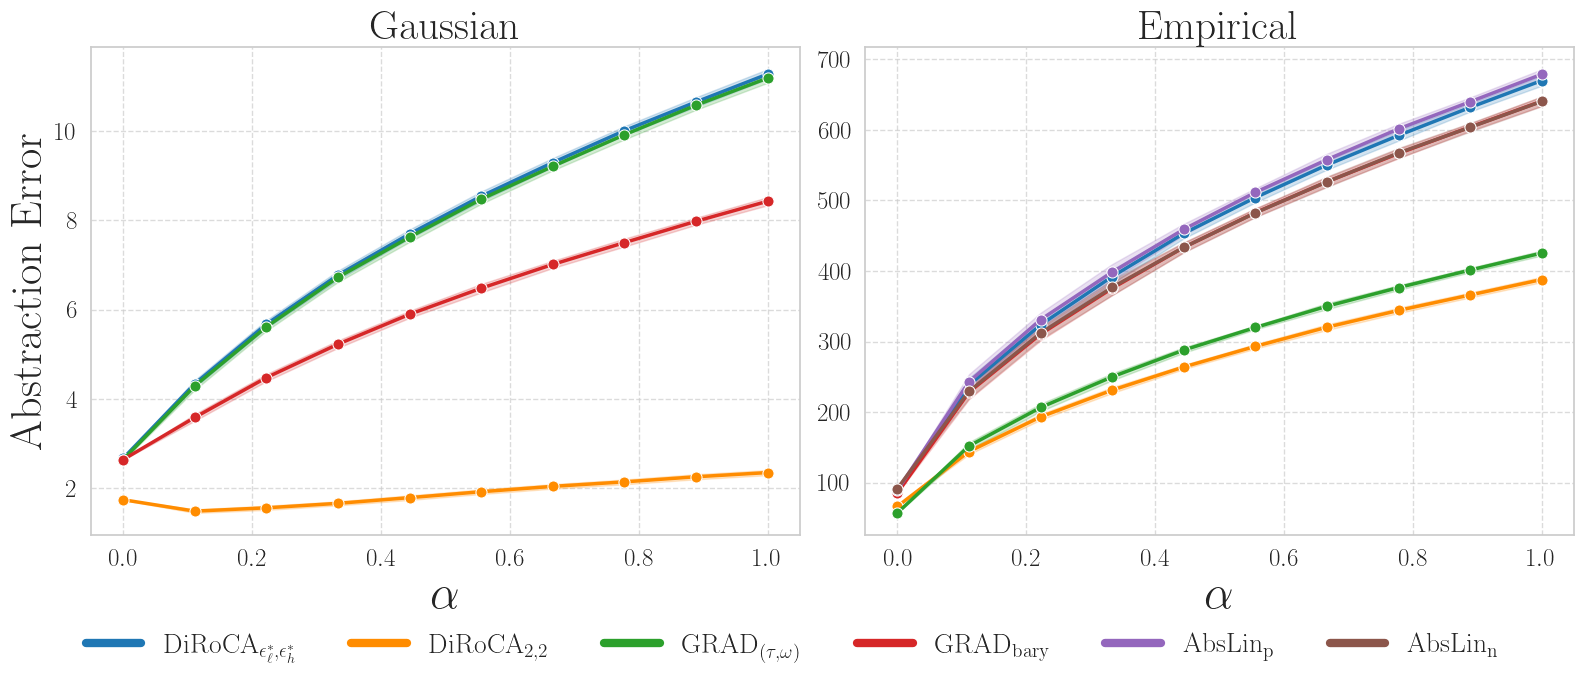

Data loaded for 'lilucas'.
Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250726_160926.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: empirical_evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250727_132334.csv
Parameters: empirical additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True


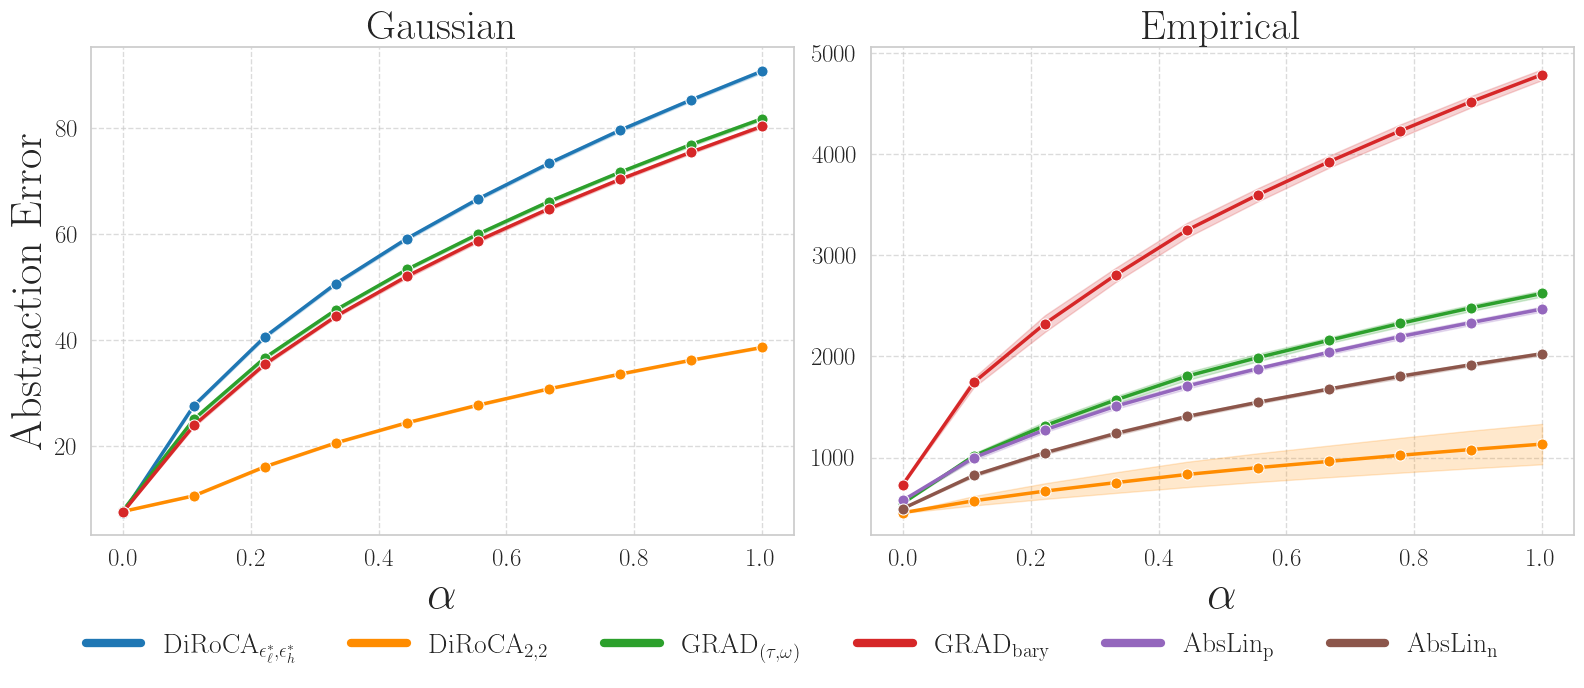

In [ ]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}"
})

# Methods and display labels
methods_to_plot = [
    'DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n'
]
display_names = [print_label_map[m] for m in methods_to_plot]

# Color palette (colorblind-friendly)
palette_colors = sns.color_palette('colorblind', n_colors=len(display_names))
color_map = dict(zip(display_names, palette_colors))
color_map = {
    r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4', 
    r'DiRoCA$_{2,2}$': 'darkorange',                            
    r'GRAD$_{(\tau, \omega)}$': '#2ca02c',                  
    r'GRAD$_{\text{bary}}$': '#d62728',                     
    r'AbsLin$_{\text{p}}$': '#9467bd',                       
    r'AbsLin$_{\text{n}}$': '#8c564b'                       
}
# Fixed noise levels per dataset
noise_level_to_plot = {
    'slc': 5.0,
    'lilucas': 10.0
}

# Loop through datasets
for experiment in ['slc', 'lilucas']:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
    combined_handles = {}

    for i, noise_type in enumerate(['gaussian', 'empirical']):
        all_data = ut.load_all_data(experiment)

        df = load_results(
            experiment=experiment,
            evaluation_type=noise_type,
            shift_type='additive',
            distribution='gaussian',
            alpha_steps=10,
            alpha_min=0.0,
            alpha_max=1.0,
            noise_steps=20,
            noise_min=0.0,
            noise_max=noise_level_to_plot[experiment],
            trials=20,
            zero_mean=True
        )

        # Replace method names
        if noise_type == 'empirical':
            df['method'] = df['method'].replace(label_map_empirical)
        else:
            df['method'] = df['method'].replace(label_map_gaussian)

        # Filter subset
        df = df[
            (df['noise_scale'] == noise_level_to_plot[experiment]) &
            (df['method'].isin(methods_to_plot))
        ].copy()

        if df.empty:
            print(f"No data for {noise_type} in {experiment}")
            continue

        df['display_name'] = df['method'].map(print_label_map)

        ax = axes[i]
        sns.lineplot(
            data=df,
            x='alpha',
            y='error',
            hue='display_name',
            hue_order=display_names,
            palette=color_map,
            marker='o',
            linewidth=2.5,
            markersize=8,
            errorbar='sd',
            ax=ax,
            legend=False
        )

        ax.set_title(f"{noise_type.capitalize()}", fontsize=30)
        ax.set_xlabel(r'$\alpha$', fontsize=34)
        if i == 0:
            ax.set_ylabel('Abstraction Error', fontsize=32)
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)

        # Collect handles
        handles, labels = ax.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in combined_handles:
                combined_handles[l] = h

    # Legend with all methods
    ordered_handles = [
        combined_handles.get(lbl, plt.Line2D([], [], color=color_map[lbl], linestyle='-', linewidth=6, label=lbl))
        for lbl in display_names
    ]

    fig.legend(ordered_handles, display_names,
               loc='lower center', ncol=6, fontsize=20, frameon=False)

    fig.tight_layout(rect=[0, 0.08, 1, 1])
    plt.savefig(f"plots/abstraction_vs_alpha_{experiment}_solidlines.png", dpi=300, bbox_inches='tight')
    plt.show()


### Fix α, vary σ

Data loaded for 'slc'.
Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250726_132833.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'slc'.
Loading: empirical_evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250727_113949.csv
Parameters: empirical additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True


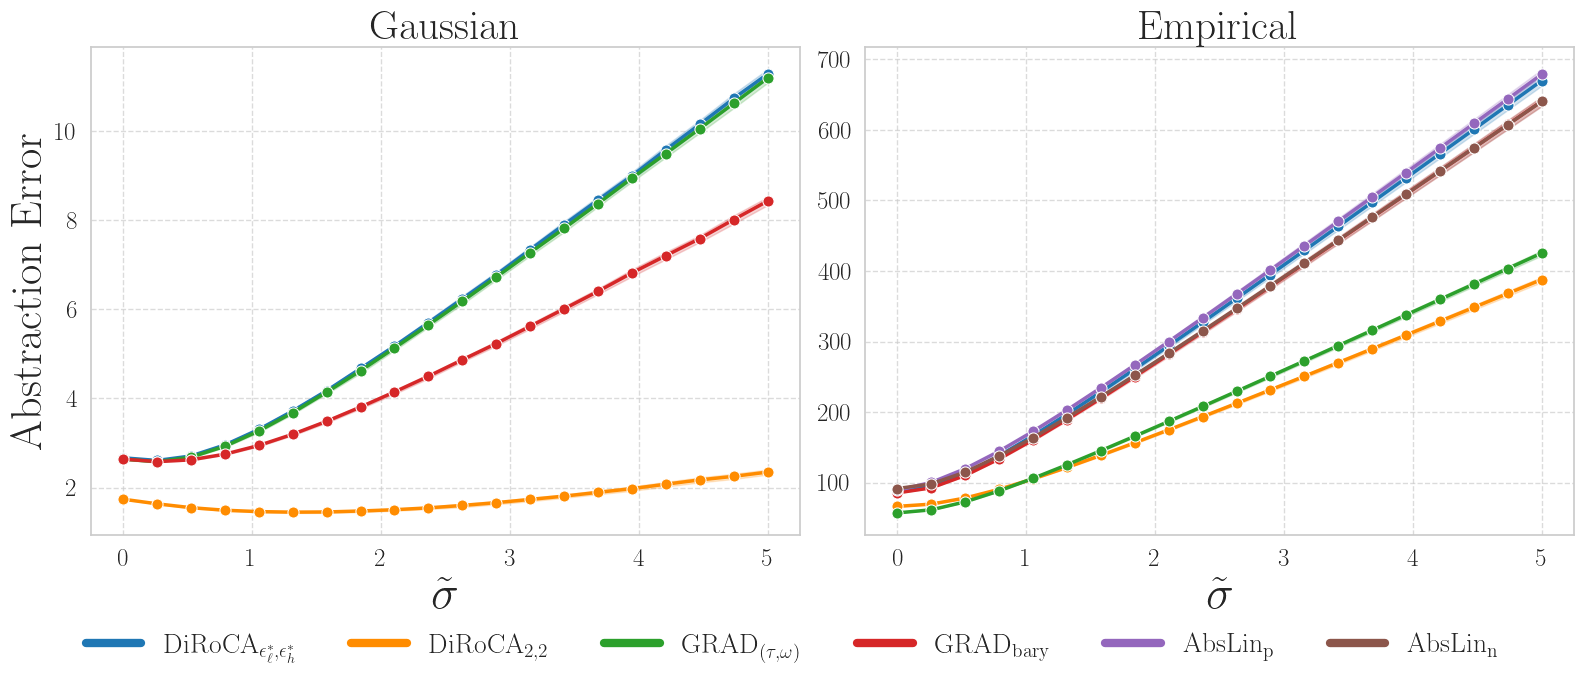

Data loaded for 'lilucas'.
Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250726_160926.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: empirical_evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250727_132334.csv
Parameters: empirical additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True


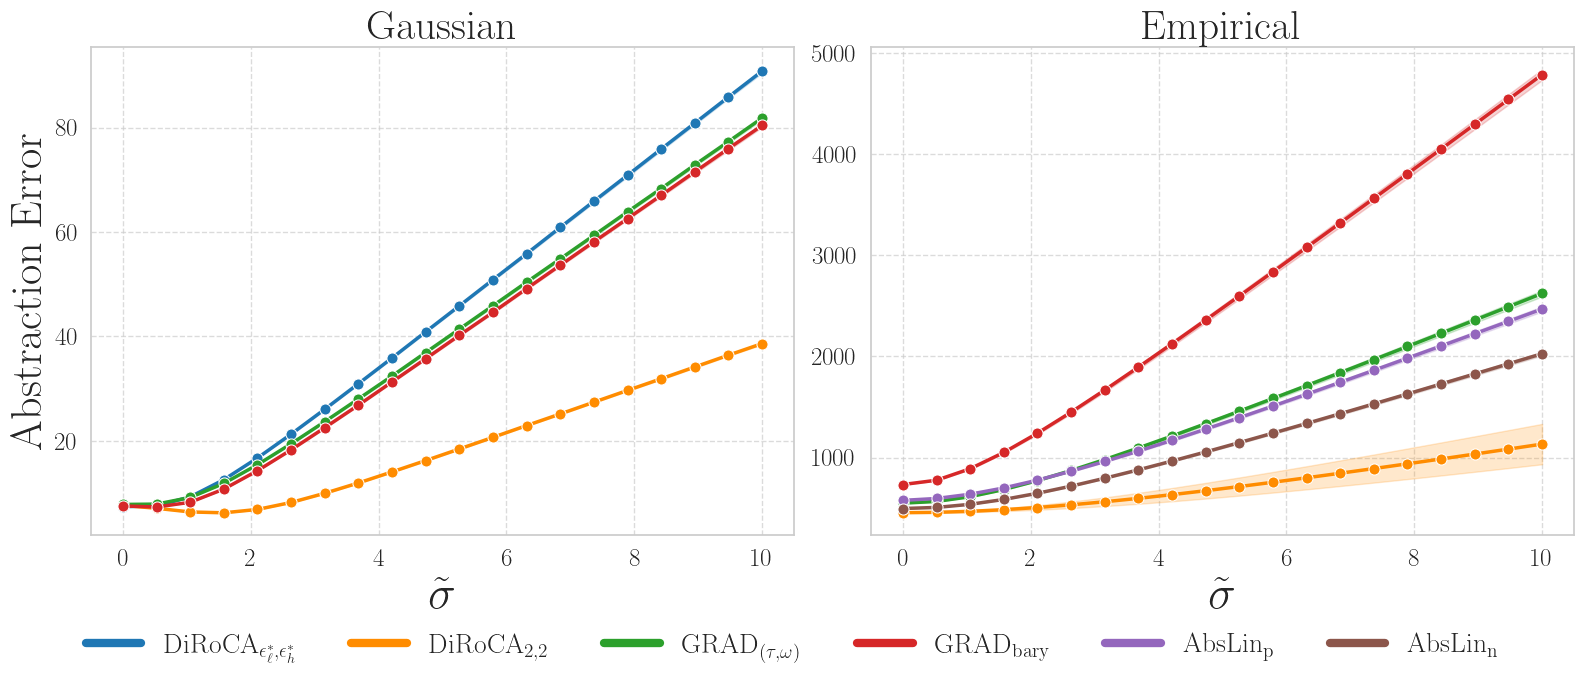

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}"
})

# Method sets and display labels
methods_to_plot = [
    'DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n'
]
display_names = [print_label_map[m] for m in methods_to_plot]

# Color map
color_map = {
    r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4',
    r'DiRoCA$_{2,2}$': 'darkorange',
    r'GRAD$_{(\tau, \omega)}$': '#2ca02c',
    r'GRAD$_{\text{bary}}$': '#d62728',
    r'AbsLin$_{\text{p}}$': '#9467bd',
    r'AbsLin$_{\text{n}}$': '#8c564b'
}

# Fixed alpha values
fixed_alpha_to_plot = {
    'slc': 1.0,
    'lilucas': 1.0
}

# Main loop
for experiment in ['slc', 'lilucas']:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
    combined_handles = {}

    for i, noise_type in enumerate(['gaussian', 'empirical']):
        all_data = ut.load_all_data(experiment)

        df = load_results(
            experiment=experiment,
            evaluation_type=noise_type,
            shift_type='additive',
            distribution='gaussian',
            alpha_steps=10,
            alpha_min=0.0,
            alpha_max=1.0,
            noise_steps=20,
            noise_min=0.0,
            noise_max=5.0 if experiment == 'slc' else 10.0,
            trials=20,
            zero_mean=True
        )

        if noise_type == 'empirical':
            df['method'] = df['method'].replace(label_map_empirical)
        else:
            df['method'] = df['method'].replace(label_map_gaussian)

        df = df[
            (np.abs(df['alpha'] - fixed_alpha_to_plot[experiment]) < 1e-4) &
            (df['method'].isin(methods_to_plot))
        ].copy()

        if df.empty:
            print(f"No data for {noise_type} in {experiment}")
            continue

        df['display_name'] = df['method'].map(print_label_map)

        ax = axes[i]
        sns.lineplot(
            data=df,
            x='noise_scale',
            y='error',
            hue='display_name',
            hue_order=display_names,
            palette=color_map,
            marker='o',
            linewidth=2.5,
            markersize=8,
            errorbar='sd',
            ax=ax,
            legend=False
        )

        ax.set_title(f"{noise_type.capitalize()}", fontsize=30)
        ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=34)
        if i == 0:
            ax.set_ylabel('Abstraction Error', fontsize=32)
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)

        # Gather handles
        handles, labels = ax.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in combined_handles:
                combined_handles[l] = h

    # Bottom legend
    ordered_handles = [
        combined_handles.get(lbl, plt.Line2D([], [], color=color_map[lbl], linestyle='-', linewidth=6, label=lbl))
        for lbl in display_names
    ]

    fig.legend(ordered_handles, display_names,
               loc='lower center', ncol=6, fontsize=20, frameon=False)

    fig.tight_layout(rect=[0, 0.08, 1, 1])
    plt.savefig(f"plots/abstraction_vs_noise_{experiment}_alpha_fixed.png", dpi=300, bbox_inches='tight')
    plt.show()


### Work on a particular setting/example

In [ ]:
experiment      = 'slc'
evaluation_type = 'empirical'

path = f"data/{experiment}/results"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

In [ ]:
final_results_df = load_results(
                                experiment=experiment,
                                evaluation_type=evaluation_type,
                                shift_type='additive',
                                distribution='gaussian',
                                alpha_steps=10,
                                alpha_min=0.0,
                                alpha_max=1.0,
                                noise_steps=20,
                                noise_min=0.0,
                                noise_max=5.0 if experiment == 'slc' else 10.0,
                                trials=20,
                                zero_mean=True
                            )


### 0-shift (α=0)

In [ ]:
df_clean             = final_results_df[final_results_df['alpha']==0.0]
summary_stats        = df_clean.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std']# / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean ± Std'}")
print("="*65)

for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

### ρ-shift (α=1, σ>0)

In [10]:
alpha_point = 1.0
noise_level_point = 5 if experiment == 'slc' else 10.0

df_point            = final_results_df[(final_results_df['alpha']==alpha_point) & (final_results_df['noise_scale']==noise_level_point)]
summary_stats        = df_point.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])


print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean ± Std'}")
print("="*65)

for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)


Method/Run                                    | Mean ± Std
Abs-LiNGAM (Noisy)                            | 640.4540 ± 0.6792
Abs-LiNGAM (Perfect)                          | 678.8894 ± 0.7115
BARYCA                                        | 640.7290 ± 0.6719
DIROCA (eps_0.107_delta_0.035)                | 669.9584 ± 0.7290
DIROCA (eps_1.0_delta_1.0)                    | 419.3966 ± 0.3895
DIROCA (eps_2.0_delta_2.0)                    | 387.9719 ± 0.3790
DIROCA (eps_4.0_delta_4.0)                    | 387.9719 ± 0.3790
DIROCA (eps_8.0_delta_8.0)                    | 387.9719 ± 0.3790
GradCA                                        | 425.5110 ± 0.3592


### GiF generation

In [24]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}"
})

methods_to_plot = ['DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n']
display_names   = [print_label_map[m] for m in methods_to_plot]

color_map = {
    r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4', 
    r'DiRoCA$_{2,2}$': 'darkorange',
    r'GRAD$_{(\tau, \omega)}$': '#2ca02c',
    r'GRAD$_{\text{bary}}$': '#d62728',
    r'AbsLin$_{\text{p}}$': '#9467bd',
    r'AbsLin$_{\text{n}}$': '#8c564b'
}


alpha_values = sorted(final_results_df['alpha'].unique())
noise_levels = sorted(final_results_df['noise_scale'].unique())

if evaluation_type == 'empirical':
    final_results_df['method'] = final_results_df['method'].replace(label_map_empirical)
else:
    final_results_df['method'] = final_results_df['method'].replace(label_map_gaussian)

# Filter to chosen methods
df_for_plotting = final_results_df[final_results_df['method'].isin(methods_to_plot)].copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(print_label_map)

y_max = df_for_plotting['error'].max()

In [28]:
fig, ax = plt.subplots(figsize=(14, 8))

def update_alpha(alpha):
    ax.clear()
    df_subset = df_for_plotting[np.isclose(df_for_plotting['alpha'], alpha)]

    sns.lineplot(
        data=df_subset,
        x='noise_scale',
        y='error',
        hue='display_name',
        hue_order=display_names,
        palette=color_map,
        marker='o',
        linewidth=2.5,
        markersize=8,
        errorbar='sd',
        ax=ax
    )

    ax.set_title(rf'$\alpha = {alpha:.2f}$', fontsize=36)
    ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=32)
    ax.set_ylabel('Abstraction Error', fontsize=32)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(title='Method', fontsize=14, title_fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving alpha...")
ani_alpha = FuncAnimation(fig, update_alpha, frames=alpha_values, blit=False, repeat=False)

# Save the GIF
ani_alpha.save('plots/robustness_vs_noise_evolving_alpha.gif', writer='pillow', fps=2)
plt.close()
# HTML(ani_alpha.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving alpha...


In [29]:
fig, ax = plt.subplots(figsize=(14, 8))

def update_noise_scale(scale):
    """This function is called for each frame to draw the plot for a specific noise scale."""
    ax.clear()
    
    df_subset = df_for_plotting[np.isclose(df_for_plotting['noise_scale'], scale)]
    
    sns.lineplot(
        data=df_subset,
        x='alpha',
        y='error',
        hue='display_name',
        hue_order=display_names,
        palette=color_map,
        marker='o',
        linewidth=2.5,
        markersize=8,
        errorbar='sd',
        ax=ax
    )
    
    ax.set_title(rf'$\tilde{{\sigma}} = {scale:.2f}$', fontsize=36)
    ax.set_xlabel(r'$\alpha$', fontsize=32)
    ax.set_ylabel('Abstraction Error', fontsize=32)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(title='Method', fontsize=14, title_fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving noise scale...")
ani_noise = FuncAnimation(fig, update_noise_scale, frames=noise_levels, blit=False, repeat=False)

# Save the GIF
ani_noise.save('plots/robustness_vs_alpha_evolving_noise.gif', writer='pillow', fps=2)
plt.close()
# HTML(ani_noise.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving noise scale...
